In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [3]:
TASKS = ["Lift", "Stack", "Wipe", "TwoArmHandoff", "Door", "PickPlaceCan", "TwoArmPegInHole"]

In [7]:
exp_prefix = "Door-Panda-OSC"

exp_path = '../runs'

all_runs = os.listdir(exp_path)

runs = [x for x in all_runs if x.startswith(exp_prefix)]

x = np.array(range(2000))

scores_mean = []
scores_std = []

for r in runs:

    folder = os.listdir(os.path.join(exp_path, r))
    assert len(folder) == 1

    print(folder)
    
    df = pd.read_csv(os.path.join(exp_path, r, folder[0], 'progress.csv'))
    y_mean = df['evaluation/Returns Mean'].to_numpy()
    y_std = df['evaluation/Returns Std'].to_numpy()

    scores_mean.append(y_mean)
    scores_std.append(y_std)

['Door_Panda_OSC_POSE_SEED59_2020_09_13_00_26_44_0000--s-0']
['Door_Panda_OSC_POSE_SEED17_2020_09_13_00_26_44_0000--s-0']
['Door_Panda_OSC_POSE_SEED83_2020_09_13_00_26_44_0000--s-0']


In [13]:
# smoothing values
def smooth(values, weight):
    smoothed = np.array(values)
    for i in range(1, smoothed.shape[0]):
        smoothed[i] = smoothed[i-1] * weight + (1 - weight) * smoothed[i]
    return smoothed

weight = 0.99 # Yuke: modify smoothing weight here
for idx, (means, stds) in enumerate(zip(scores_mean, scores_std)):
    scores_mean[idx] = smooth(means, weight)
    scores_std[idx] = smooth(stds, weight)

In [14]:
df.columns

Index(['replay_buffer/size', 'trainer/QF1 Loss', 'trainer/QF2 Loss',
       'trainer/Policy Loss', 'trainer/Q1 Predictions Mean',
       'trainer/Q1 Predictions Std', 'trainer/Q1 Predictions Max',
       'trainer/Q1 Predictions Min', 'trainer/Q2 Predictions Mean',
       'trainer/Q2 Predictions Std', 'trainer/Q2 Predictions Max',
       'trainer/Q2 Predictions Min', 'trainer/Q Targets Mean',
       'trainer/Q Targets Std', 'trainer/Q Targets Max',
       'trainer/Q Targets Min', 'trainer/Log Pis Mean', 'trainer/Log Pis Std',
       'trainer/Log Pis Max', 'trainer/Log Pis Min', 'trainer/Policy mu Mean',
       'trainer/Policy mu Std', 'trainer/Policy mu Max',
       'trainer/Policy mu Min', 'trainer/Policy log std Mean',
       'trainer/Policy log std Std', 'trainer/Policy log std Max',
       'trainer/Policy log std Min', 'trainer/Alpha', 'trainer/Alpha Loss',
       'exploration/num steps total', 'exploration/num paths total',
       'exploration/path length Mean', 'exploration/path l

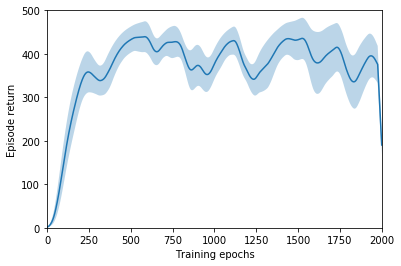

In [15]:
N = 50
y_range = (0, 500)

scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)

score_mean = scores_mean.mean(0)
score_std  = scores_std.mean(0)

score_std = np.convolve(score_std, np.ones((N,))/N, mode='same')
score_mean = np.convolve(score_mean, np.ones((N,))/N, mode='same')

plt.xlabel('Training epochs')
plt.ylabel('Episode return')

plt.xlim(0, 2000)
plt.ylim(0, 500)

plt.plot(x, score_mean)

confidence_min = score_mean - score_std # 90% confidence band
confidence_max = score_mean + score_std

plt.fill_between(x, confidence_min, confidence_max, alpha=0.3)
plt.savefig('%s.pdf' % exp_prefix)
plt.show()